<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with LSTM

- Yongyang Liu


## Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


In [2]:
# Path to save the trained model
Path = os.getcwd()
PATH = "Trained_model/LSTM.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


## Data Loading

In [3]:
x = np.loadtxt('Sample_data/input.txt', delimiter='\t')
print(x.shape)

y = np.loadtxt('Sample_data/output.txt', delimiter='\t')
print(y.shape)

time_len    = 320                                   #time length for sample data for each vehicle           
veh_len     = 5                                     #vehicle length
seq_length  = 5                                     #Input sequency lenght, should not be too long. Use the past seq-length sample data to predict the next step state

time_length = len(x)                                #time length for total sample data
num_veh     = int(time_length/time_len)             #number of vehicles in sample data
print(num_veh)

(288000, 14)
(288000,)
900


## Data Processing

In [4]:
training_size = 700
validation_size = 100
testing_size = 100

dataX       = Variable(torch.Tensor(np.array(x)))   #Input data
y.astype(int)
dataY       = Variable(torch.from_numpy(y).long())  #Output target
sample_len  = time_len - seq_length                 # sample length from each vehicle

#Samples initialization
trainX      = Variable(torch.empty(training_size*sample_len, seq_length, 14))
trainY      = Variable(torch.empty((training_size*sample_len), dtype=torch.long))
for j in range(training_size): 
    for i in range(sample_len):
        #input data
        trainX[j*sample_len+i,0:seq_length] = dataX[j*time_len+i : j*time_len+i+seq_length]
        #output target
        trainY[j*sample_len+i] = dataY[j*time_len+i+seq_length]       
print(trainX.shape)
print(trainY.shape)

validX      = Variable(torch.empty(validation_size*sample_len, seq_length, 14))
validY      = Variable(torch.empty((validation_size*sample_len), dtype=torch.long))
for j in range(validation_size): 
    for i in range(sample_len):
        j_0 = j + training_size   
        validX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        validY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(validX.shape)
print(validY.shape)

testX       = Variable(torch.empty(validation_size*sample_len, seq_length, 14)) 
testY       = Variable(torch.empty((validation_size*sample_len), dtype=torch.long))
for j in range(testing_size): 
    for i in range(sample_len):
        j_0 = j + training_size + validation_size
        testX[j*sample_len+i,0:seq_length] = dataX[j_0*time_len+i : j_0*time_len+i+seq_length]       
        testY[j*sample_len+i] = dataY[j_0*time_len+i+seq_length]     
print(testX.shape)
print(testY.shape)



#CUDA
trainX = trainX.to(device)
trainY = trainY.to(device)
validX = validX.to(device)
validY = validY.to(device)
testX = testX.to(device)
testY = testY.to(device)


torch.Size([220500, 5, 14])
torch.Size([220500])
torch.Size([31500, 5, 14])
torch.Size([31500])
torch.Size([31500, 5, 14])
torch.Size([31500])


## Model

In [5]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size1, hidden_size2, num_layers): 
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size1, num_layers=num_layers, batch_first = True)
        self.lstm2 = nn.LSTM(input_size=hidden_size1, hidden_size=hidden_size2, num_layers=num_layers, batch_first = True)
       
        self.fc1 = nn.Linear(hidden_size2, int(hidden_size2/2))
        self.bn1 = nn.BatchNorm1d(int(hidden_size2/2))
        self.fc2 = nn.Linear(int(hidden_size2/2), int(hidden_size2/4))  
        self.bn2 = nn.BatchNorm1d(int(hidden_size2/4))
        self.fc3 = nn.Linear(int(hidden_size2/4), num_classes)
        
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        h_00 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size1)).to(device)
        h_01 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size2)).to(device)
        c_00 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size1)).to(device)
        c_01 = Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size2)).to(device)
        
        # Propagate input through RNN
        out, (_, _) = self.lstm1(x, (h_00, c_00))
        uls, (h_out, _) = self.lstm2(out, (h_01, c_01))  # seq_2_one, so we use h_out instead of uls
        
        h_out = h_out.view(-1, self.hidden_size2)
        output = F.relu(self.drop1(self.bn1(self.fc1(h_out))))
        output = F.relu(self.drop2(self.bn2(self.fc2(output))))
        output = self.fc3(output)
        
        return output
    
    def run(self, x):
        out = self.forward(x)
        out = torch.max(out, 1)[1]
        return out

## Training

Model's state_dict:
lstm1.weight_ih_l0 	 torch.Size([512, 14])
lstm1.weight_hh_l0 	 torch.Size([512, 128])
lstm1.bias_ih_l0 	 torch.Size([512])
lstm1.bias_hh_l0 	 torch.Size([512])
lstm2.weight_ih_l0 	 torch.Size([256, 128])
lstm2.weight_hh_l0 	 torch.Size([256, 64])
lstm2.bias_ih_l0 	 torch.Size([256])
lstm2.bias_hh_l0 	 torch.Size([256])
fc1.weight 	 torch.Size([32, 64])
fc1.bias 	 torch.Size([32])
bn1.weight 	 torch.Size([32])
bn1.bias 	 torch.Size([32])
bn1.running_mean 	 torch.Size([32])
bn1.running_var 	 torch.Size([32])
bn1.num_batches_tracked 	 torch.Size([])
fc2.weight 	 torch.Size([16, 32])
fc2.bias 	 torch.Size([16])
bn2.weight 	 torch.Size([16])
bn2.bias 	 torch.Size([16])
bn2.running_mean 	 torch.Size([16])
bn2.running_var 	 torch.Size([16])
bn2.num_batches_tracked 	 torch.Size([])
fc3.weight 	 torch.Size([2, 16])
fc3.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': Fa

C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
C:\Users\yliu3119\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


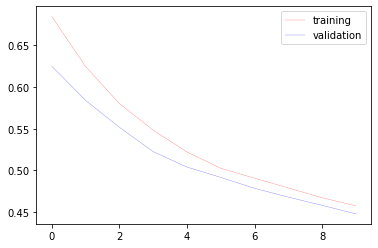

Epoch: 10, loss_train: 0.146079480648, loss_valid: 0.144189611077, best loss: 0.143208086491
Epoch: 20, loss_train: 0.099941894412, loss_valid: 0.094557158649, best loss: 0.093910738826
Epoch: 30, loss_train: 0.084432341158, loss_valid: 0.078686036170, best loss: 0.075724378228
Epoch: 40, loss_train: 0.071883283556, loss_valid: 0.067668356001, best loss: 0.066587485373
Epoch: 50, loss_train: 0.064234510064, loss_valid: 0.059261348099, best loss: 0.059082731605
Epoch L1 regularization 0.00000007


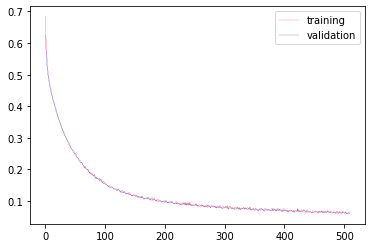

Epoch: 60, loss_train: 0.061720311642, loss_valid: 0.056652396917, best loss: 0.056652396917
Epoch: 70, loss_train: 0.058324981481, loss_valid: 0.058565251529, best loss: 0.054042331874
Epoch: 80, loss_train: 0.053504165262, loss_valid: 0.053994286805, best loss: 0.052856091410
Epoch: 90, loss_train: 0.053009022027, loss_valid: 0.052140194923, best loss: 0.050548542291
Epoch: 100, loss_train: 0.052829168737, loss_valid: 0.050145525485, best loss: 0.050041936338
Epoch L1 regularization 0.00000007


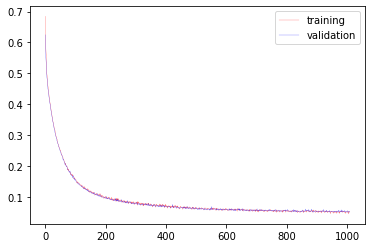

Epoch: 110, loss_train: 0.055539093912, loss_valid: 0.051387622952, best loss: 0.049077875912
Epoch: 120, loss_train: 0.053811572492, loss_valid: 0.051842626184, best loss: 0.048311680555
Epoch: 130, loss_train: 0.052029959857, loss_valid: 0.049751851708, best loss: 0.047590576112
Epoch: 140, loss_train: 0.049247670919, loss_valid: 0.049928627908, best loss: 0.047590576112
Epoch: 150, loss_train: 0.049005206674, loss_valid: 0.047160867602, best loss: 0.047160867602
Epoch L1 regularization 0.00000007


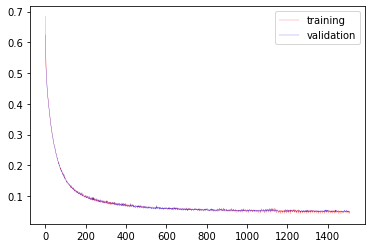

Epoch: 160, loss_train: 0.049863867462, loss_valid: 0.048539813608, best loss: 0.046544492245
Epoch: 170, loss_train: 0.050265453756, loss_valid: 0.050020400435, best loss: 0.046544492245
Epoch: 180, loss_train: 0.048212308437, loss_valid: 0.048981998116, best loss: 0.046423755586
Epoch: 190, loss_train: 0.049526222050, loss_valid: 0.048175554723, best loss: 0.046111345291
Epoch: 200, loss_train: 0.049141909927, loss_valid: 0.048700876534, best loss: 0.045644722879
Epoch L1 regularization 0.00000007


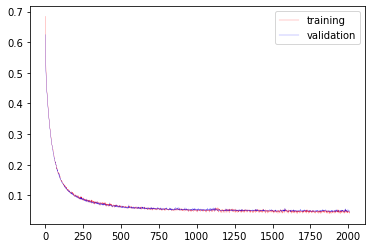

Epoch: 210, loss_train: 0.047651261091, loss_valid: 0.048063747585, best loss: 0.045644722879
Epoch: 220, loss_train: 0.048505373299, loss_valid: 0.048094563186, best loss: 0.045151226223
Epoch: 230, loss_train: 0.046408817172, loss_valid: 0.046126764268, best loss: 0.045151226223
Epoch: 240, loss_train: 0.047507535666, loss_valid: 0.047019410878, best loss: 0.045151226223
Epoch: 250, loss_train: 0.050128549337, loss_valid: 0.047433022410, best loss: 0.045137807727
Epoch L1 regularization 0.00000007


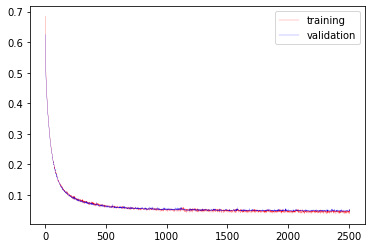

Epoch: 260, loss_train: 0.047705523670, loss_valid: 0.049825366586, best loss: 0.044751472771
Epoch: 270, loss_train: 0.046445164829, loss_valid: 0.048761896789, best loss: 0.044751472771
Epoch: 280, loss_train: 0.043172553182, loss_valid: 0.047934010625, best loss: 0.044751472771
Epoch: 290, loss_train: 0.047030195594, loss_valid: 0.046540822834, best loss: 0.044751472771
Epoch: 300, loss_train: 0.044143274426, loss_valid: 0.047200657427, best loss: 0.044751472771
Epoch L1 regularization 0.00000008


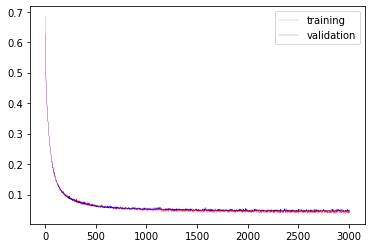

In [6]:

num_epochs    = 301
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = 2  
num_layers = 1

model = LSTM(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = nn.CrossEntropyLoss()     
# This criterion combines LogSoftmax and NLLLoss in one single class. 
# So, if you define the last layer as softmax, then the criterion shoube be NLLLoss. 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#learning rate adjustment. learning rate * 0.75 every 2000 epoch
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.75)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

best_loss = 99999999999999.99
best_epoch = 0
Loss = [] 
Loss_t = []
t_len = int(trainX.size(0)/10)
# Train the model

for epoch in range(num_epochs):   
    for j in range(10):     # input size is too big. We split into 10 piece
        torch.cuda.empty_cache()
        train_X_temp = trainX[j*t_len:j*t_len+t_len] # 0 to test_size
        train_Y_temp = trainY[j*t_len:j*t_len+t_len]
        
        train_X_temp = train_X_temp.to(device)
        train_Y_temp = train_Y_temp.to(device)
        
        outputs = model(train_X_temp)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, train_Y_temp)
        # L1 regularization
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
            if 'weight' in name:
                L1_reg = L1_reg + torch.norm(param, 1)
            
        loss += L1_lambda * L1_reg

        loss.backward()
        
        optimizer.step()
        #scheduler.step()
        
        outputs = model(testX)
        loss_t = criterion(outputs, testY)# + L1_lambda * L1_reg
    
        Loss.append(loss.item())
        Loss_t.append(loss_t.item())
        
        if loss_t.item() < best_loss:
            torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        }, PATH)
            best_loss = loss_t.item()
    
    if epoch % 10 == 0:
        print("Epoch: %d, loss_train: %1.12f, loss_valid: %1.12f, best loss: %1.12f" % (epoch, loss.item(), loss_t.item(), best_loss))
              
    if epoch % 50 == 0:
        print("Epoch L1 regularization %1.8f" % (L1_lambda * L1_reg))
        plt.plot(Loss,c='r', linewidth=0.2, Label = 'training')
        plt.plot(Loss_t,c='b', linewidth=0.2, Label = 'validation')
        #plt.ylim(0, 0.00001)
        #plt.axhline(y=0.0002, c='black', linestyle='--', linewidth=0.1)
        #plt.axhline(y=0.0001, c='black', linestyle='--', linewidth=0.1)
        plt.legend()
        plt.show()



## Save model

In [37]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

## Load model

In [7]:
num_epochs    = 2001
learning_rate = 0.001
L1_lambda     = 0.00000000001

input_size   = trainX.size(2)
hidden_size1 = 128
hidden_size2 = 64
num_classes = 2
num_layers = 1

model = LSTM(num_classes, input_size, hidden_size1, hidden_size2, num_layers) 
model.to(device)  #CUDA

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if device == "cuda:0":
    checkpoint = torch.load(PATH)
else:
    checkpoint = torch.load(PATH, map_location = torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


## Test

vehicle 0  MSE Loss: 0.00634921


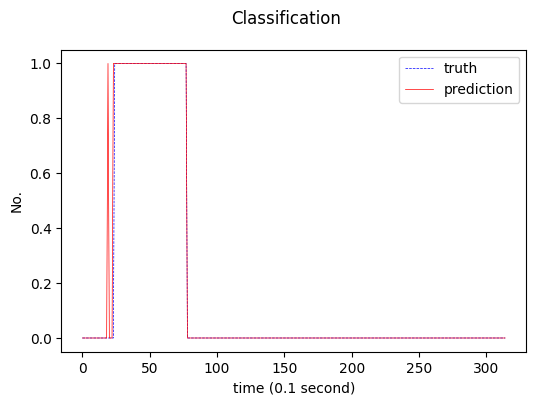

vehicle 1  MSE Loss: 0.01269841


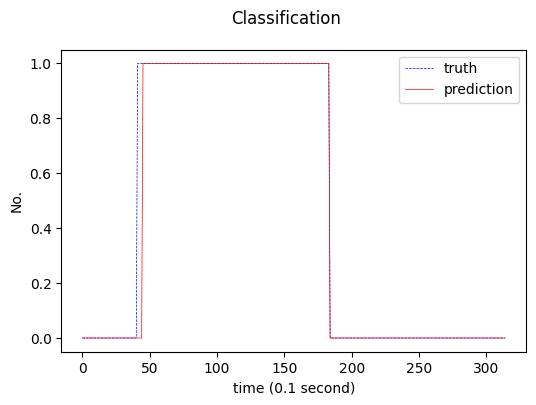

vehicle 2  MSE Loss: 0.00634921


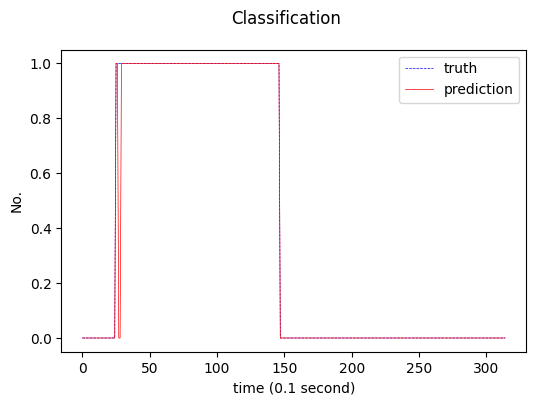

vehicle 3  MSE Loss: 0.01269841


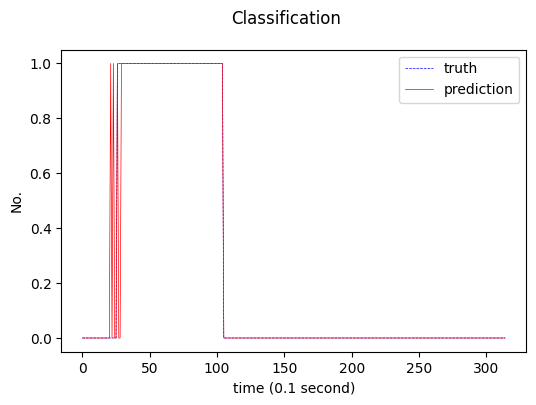

vehicle 4  MSE Loss: 0.00317460


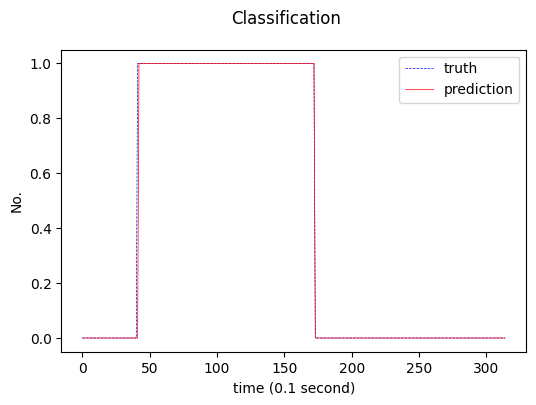

vehicle 5  MSE Loss: 0.00952381


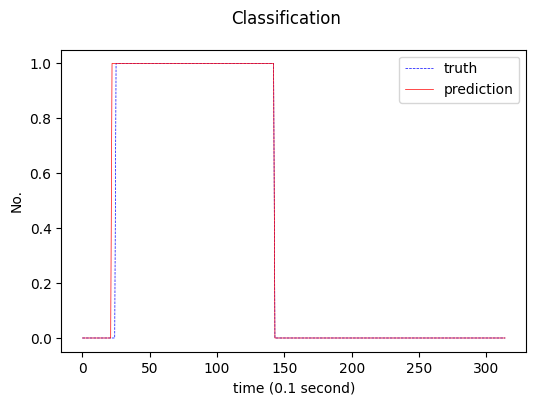

vehicle 6  MSE Loss: 0.03492063


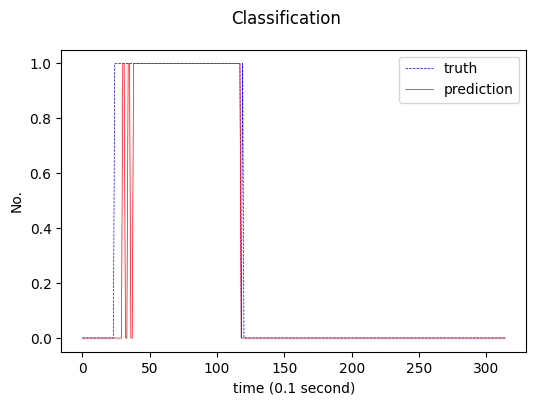

vehicle 7  MSE Loss: 0.00952381


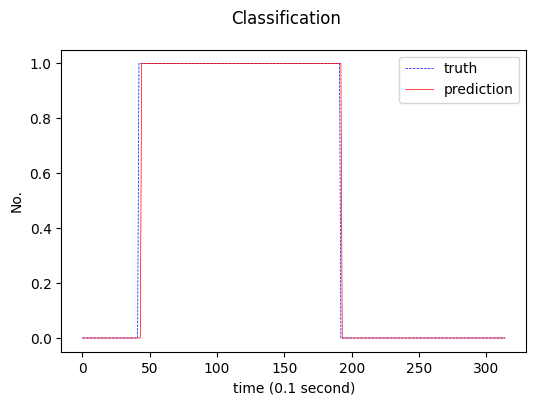

vehicle 8  MSE Loss: 0.01587302


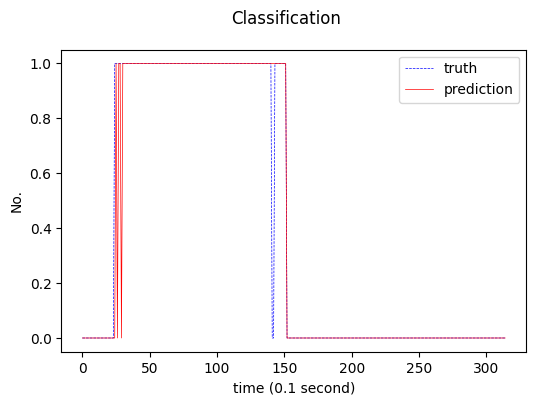

vehicle 9  MSE Loss: 0.01587302


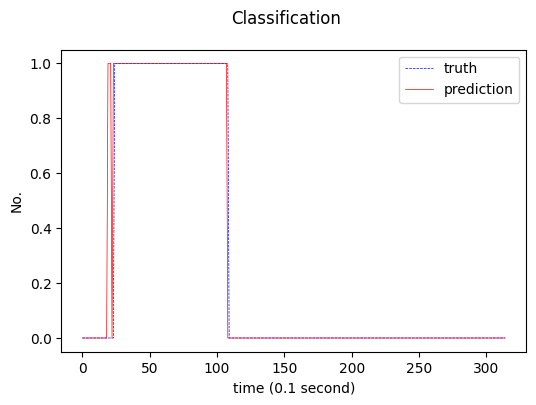

vehicle 10  MSE Loss: 0.01587302


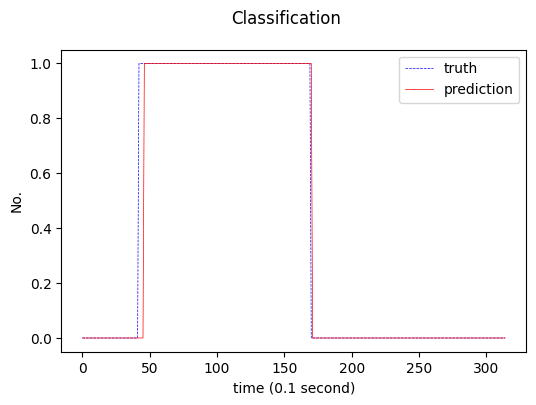

vehicle 11  MSE Loss: 0.00952381


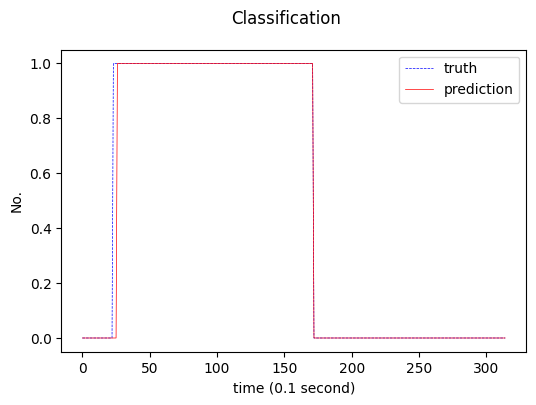

vehicle 12  MSE Loss: 0.01269841


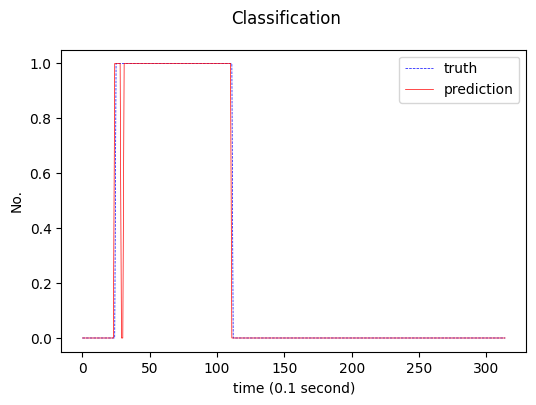

vehicle 13  MSE Loss: 0.00634921


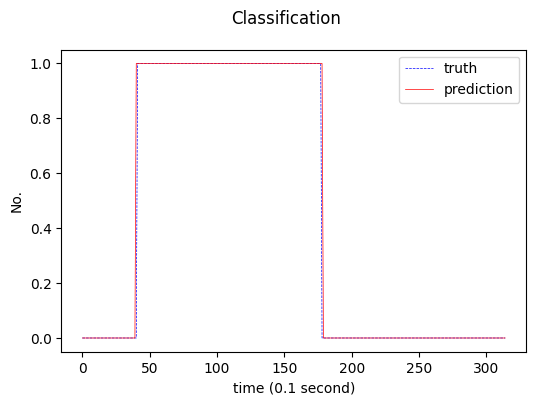

vehicle 14  MSE Loss: 0.02222222


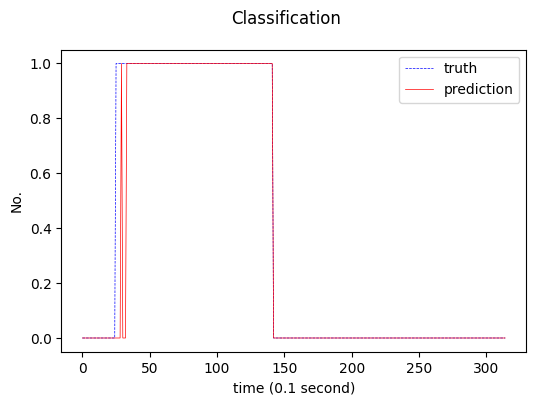

vehicle 15  MSE Loss: 0.03809524


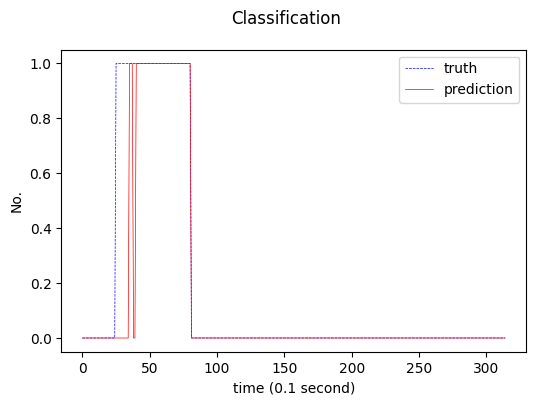

vehicle 16  MSE Loss: 0.00634921


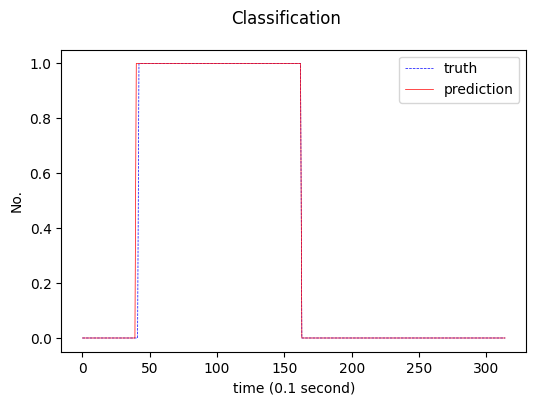

vehicle 17  MSE Loss: 0.01904762


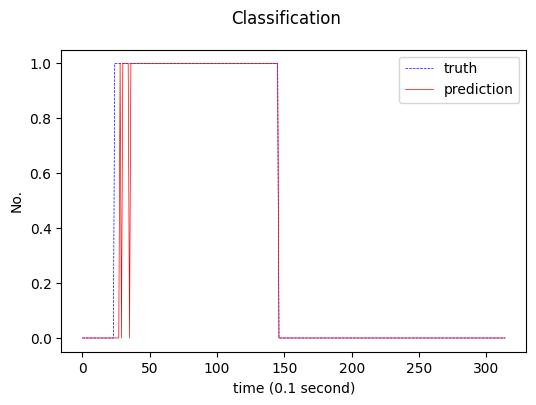

vehicle 18  MSE Loss: 0.01269841


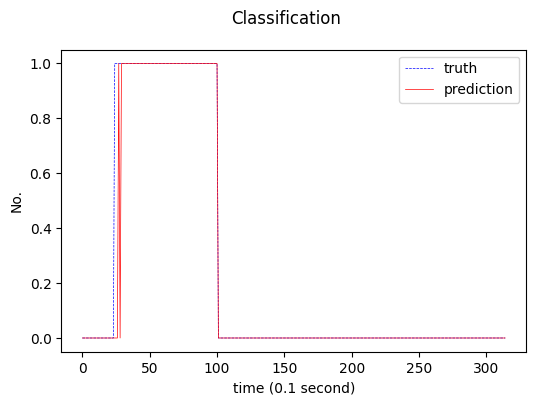

vehicle 19  MSE Loss: 0.00317460


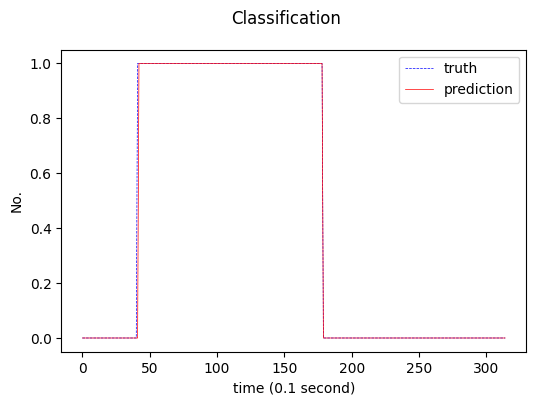

vehicle 20  MSE Loss: 0.01904762


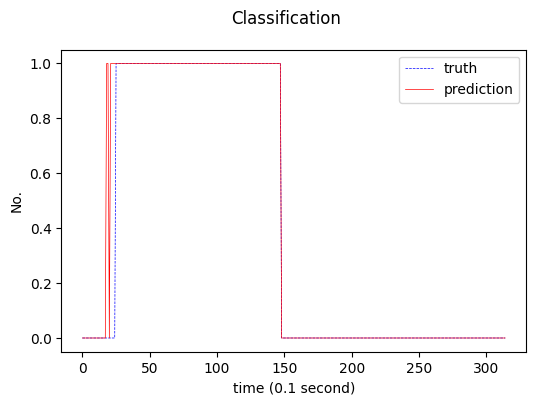

vehicle 21  MSE Loss: 0.01587302


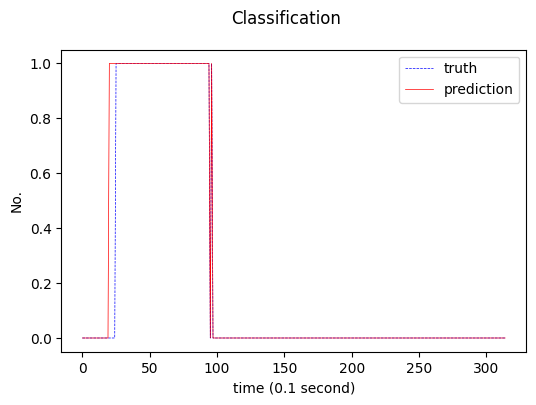

vehicle 22  MSE Loss: 0.00634921


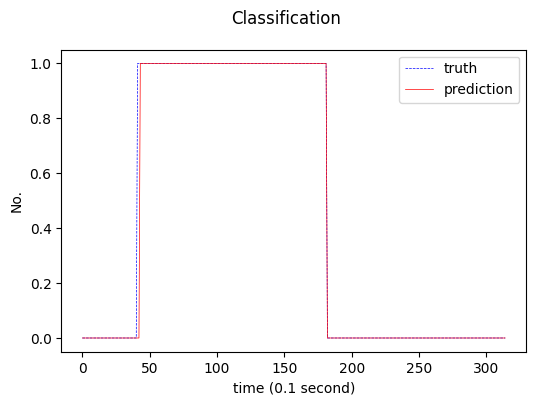

vehicle 23  MSE Loss: 0.02222222


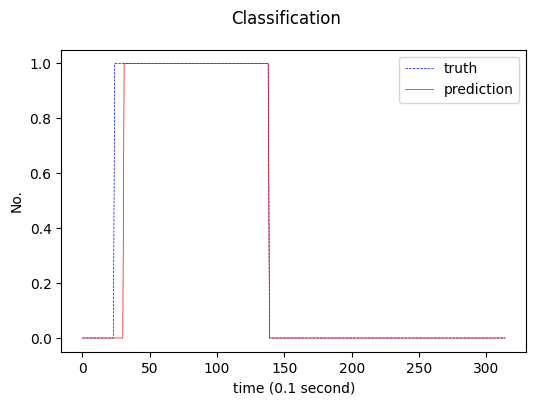

vehicle 24  MSE Loss: 0.02222222


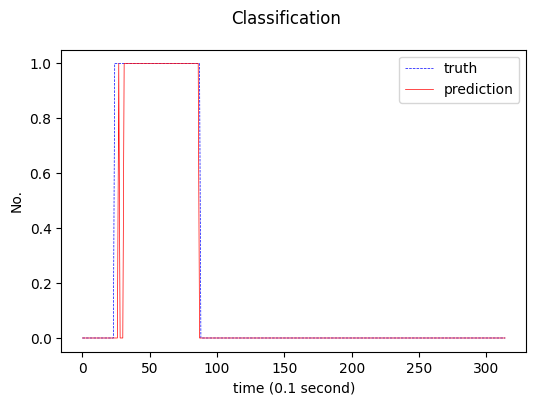

vehicle 25  MSE Loss: 0.02222222


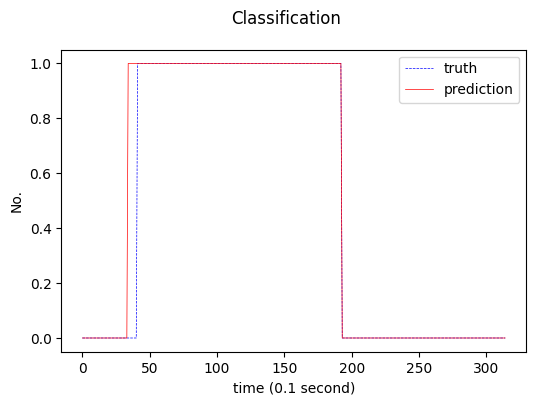

vehicle 26  MSE Loss: 0.00634921


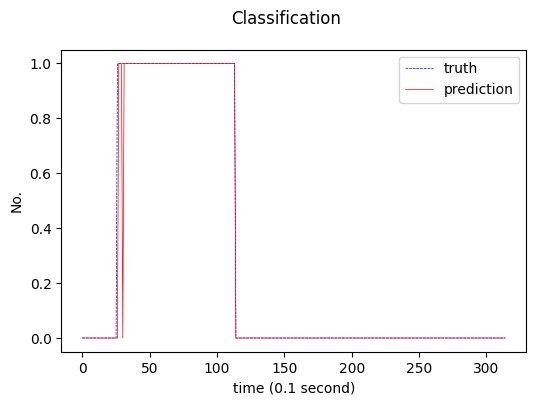

vehicle 27  MSE Loss: 0.01587302


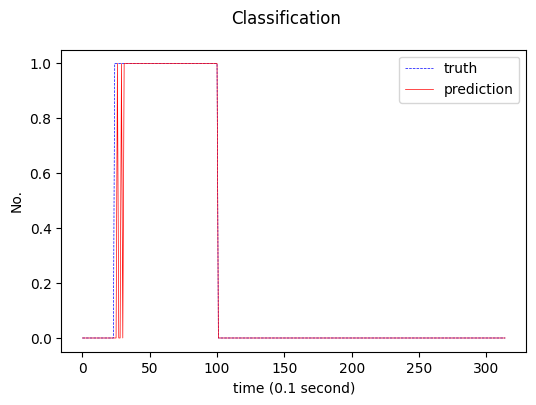

vehicle 28  MSE Loss: 0.00952381


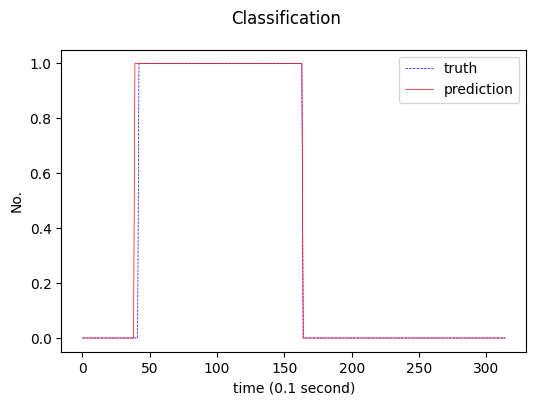

vehicle 29  MSE Loss: 0.00952381


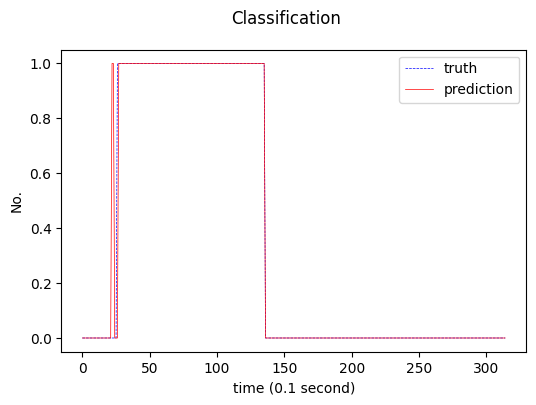

vehicle 30  MSE Loss: 0.00952381


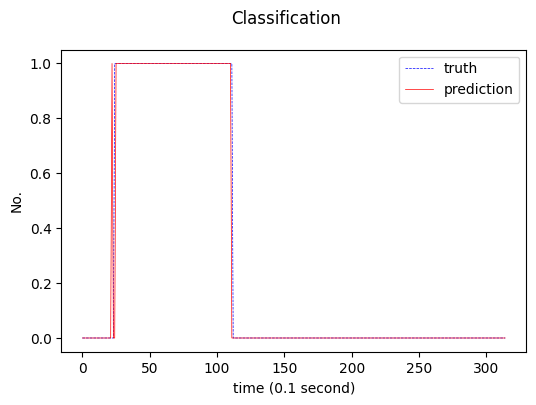

vehicle 31  MSE Loss: 0.00317460


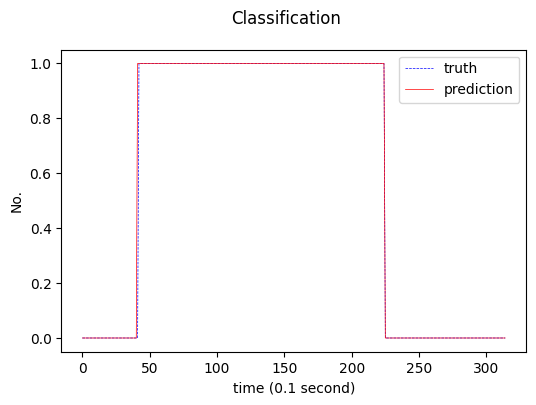

vehicle 32  MSE Loss: 0.02857143


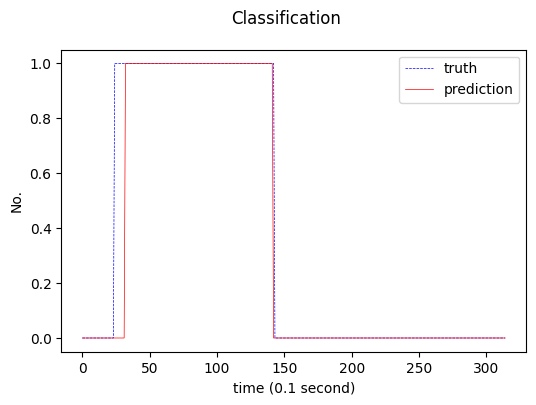

vehicle 33  MSE Loss: 0.00634921


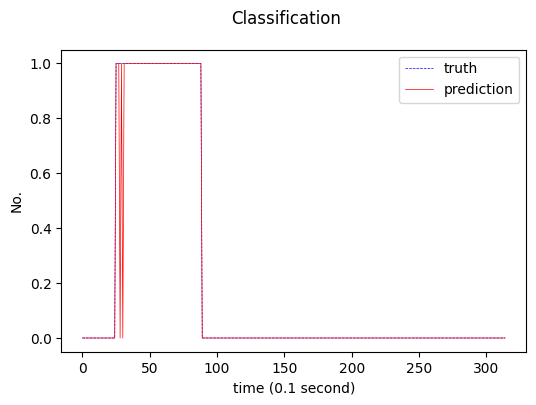

vehicle 34  MSE Loss: 0.00634921


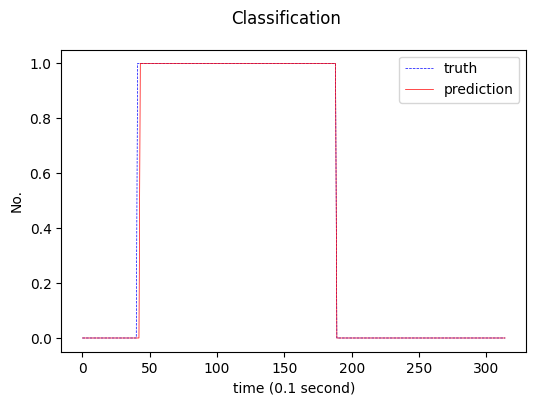

vehicle 35  MSE Loss: 0.01269841


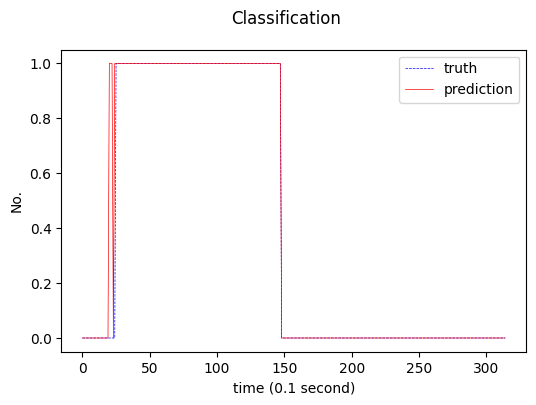

vehicle 36  MSE Loss: 0.00634921


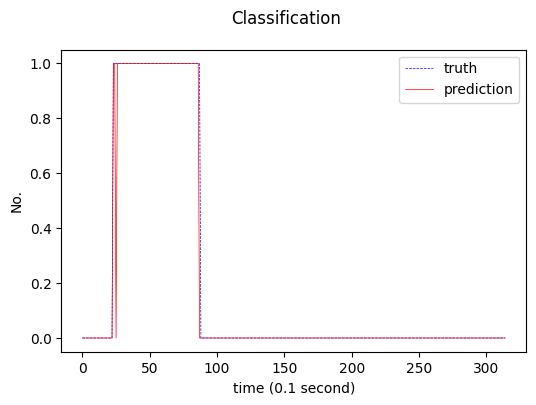

vehicle 37  MSE Loss: 0.00634921


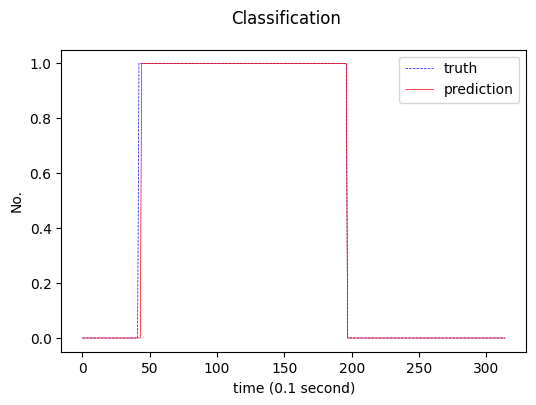

vehicle 38  MSE Loss: 0.03174603


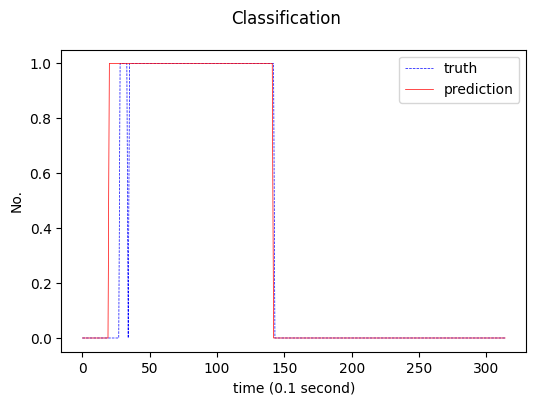

vehicle 39  MSE Loss: 0.01904762


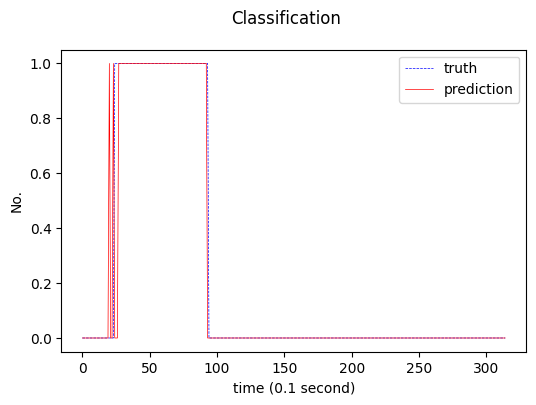

vehicle 40  MSE Loss: 0.01904762


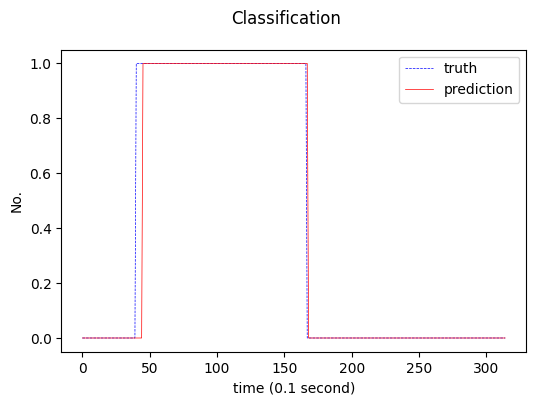

vehicle 41  MSE Loss: 0.00000000


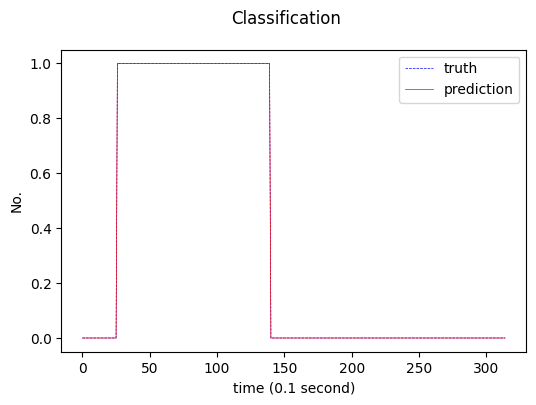

vehicle 42  MSE Loss: 0.01904762


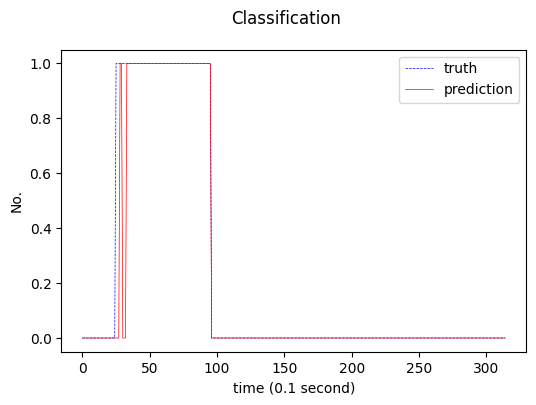

vehicle 43  MSE Loss: 0.00634921


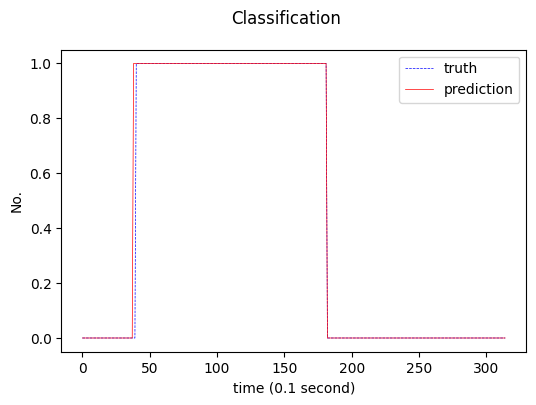

vehicle 44  MSE Loss: 0.00952381


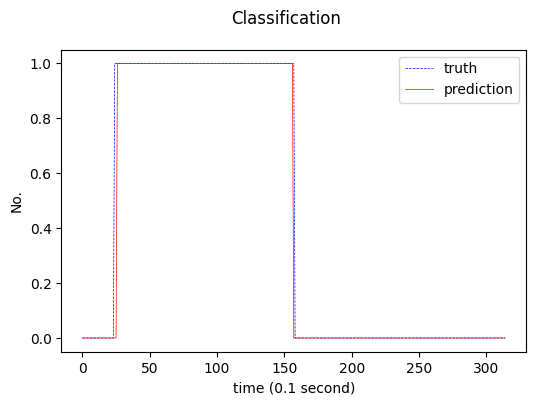

vehicle 45  MSE Loss: 0.00634921


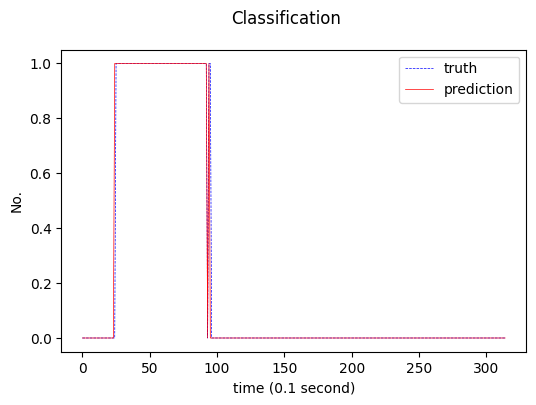

vehicle 46  MSE Loss: 0.00634921


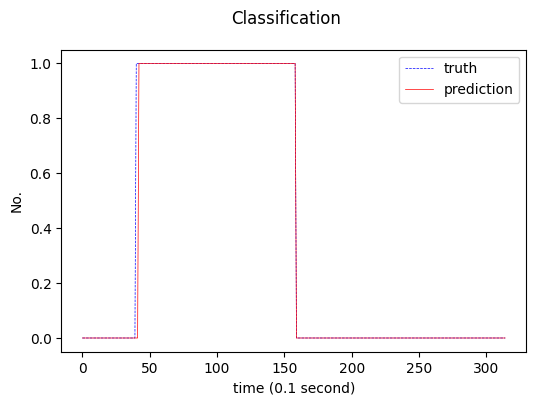

vehicle 47  MSE Loss: 0.07301587


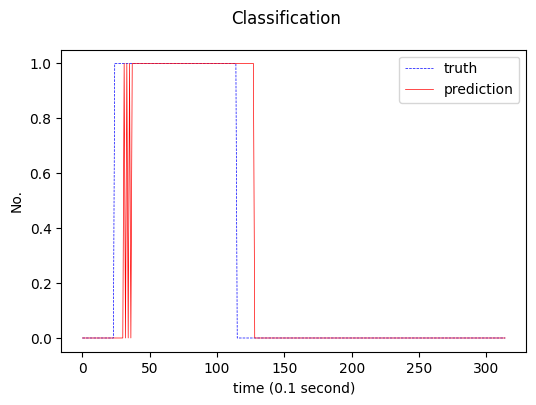

vehicle 48  MSE Loss: 0.00634921


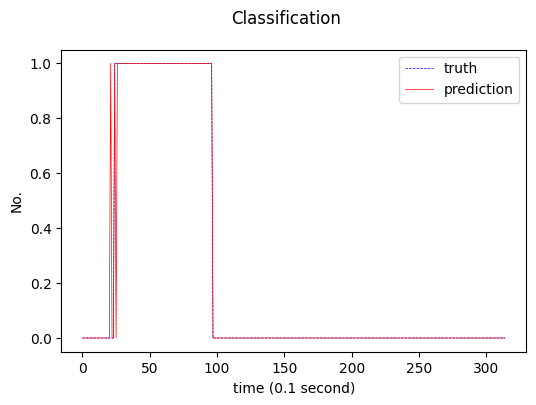

vehicle 49  MSE Loss: 0.00952381


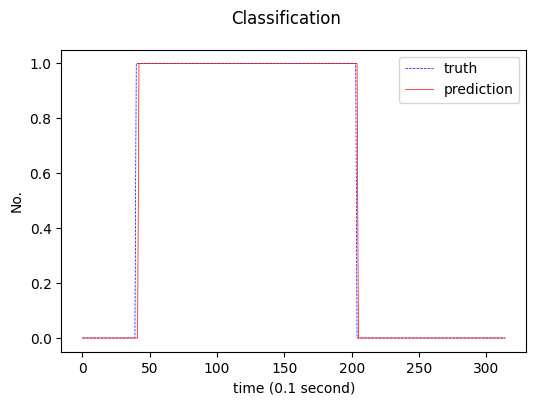

vehicle 50  MSE Loss: 0.00317460


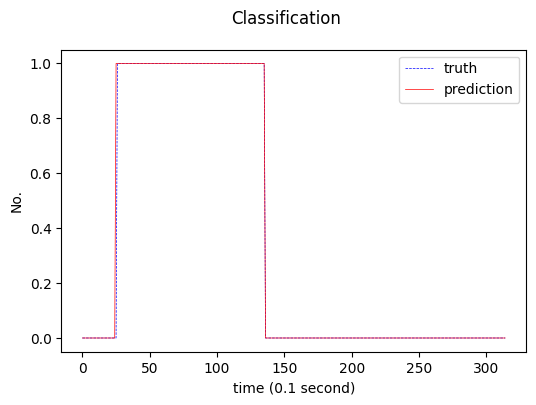

vehicle 51  MSE Loss: 0.02222222


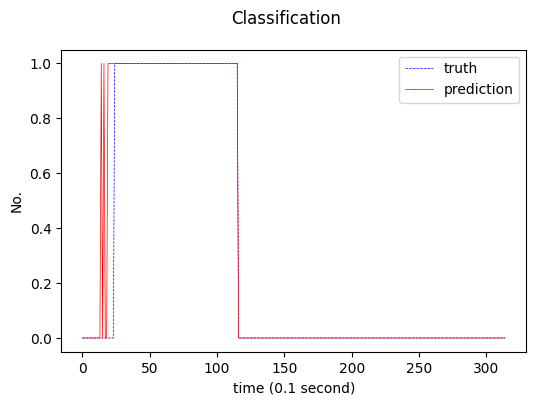

vehicle 52  MSE Loss: 0.01587302


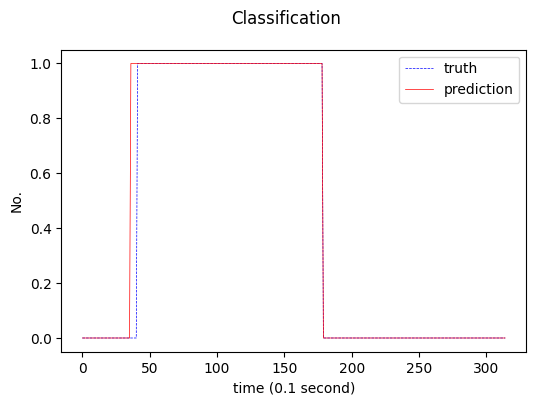

vehicle 53  MSE Loss: 0.00952381


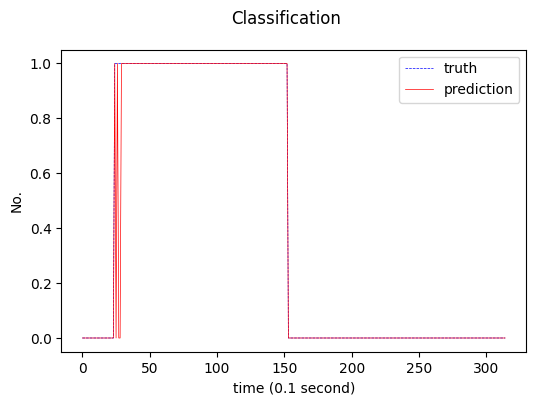

vehicle 54  MSE Loss: 0.00952381


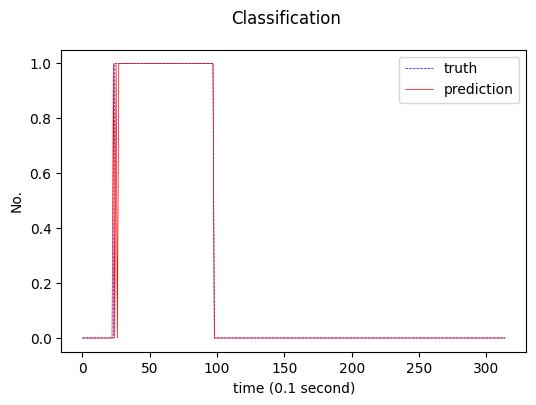

vehicle 55  MSE Loss: 0.00634921


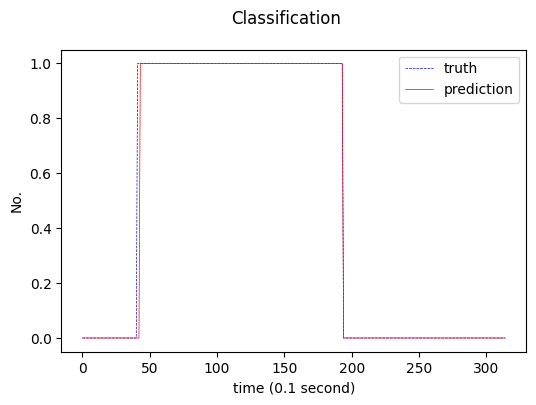

vehicle 56  MSE Loss: 0.01269841


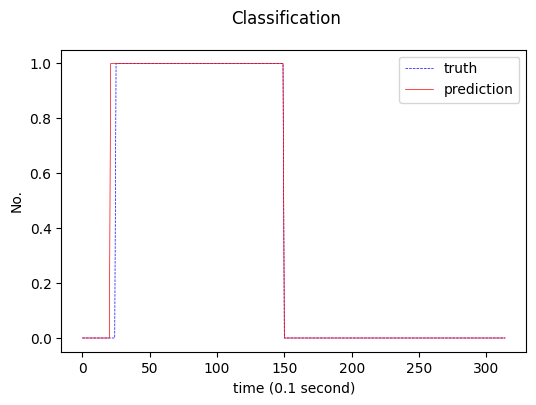

vehicle 57  MSE Loss: 0.06984127


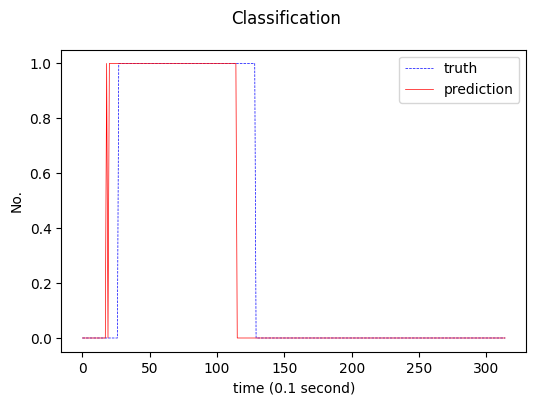

vehicle 58  MSE Loss: 0.00634921


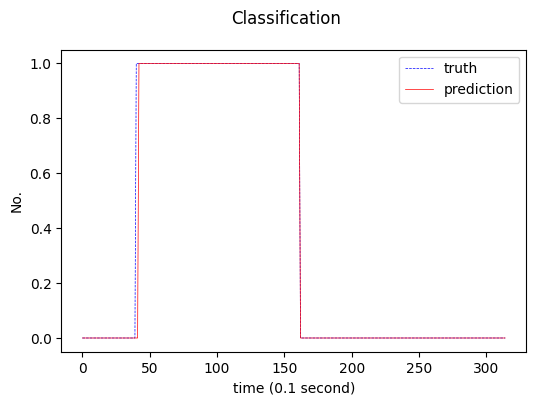

vehicle 59  MSE Loss: 0.02857143


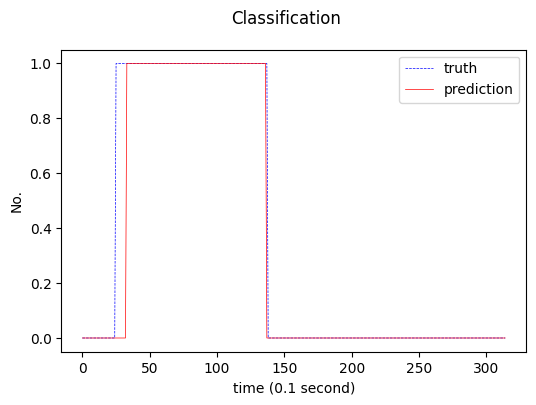

vehicle 60  MSE Loss: 0.02857143


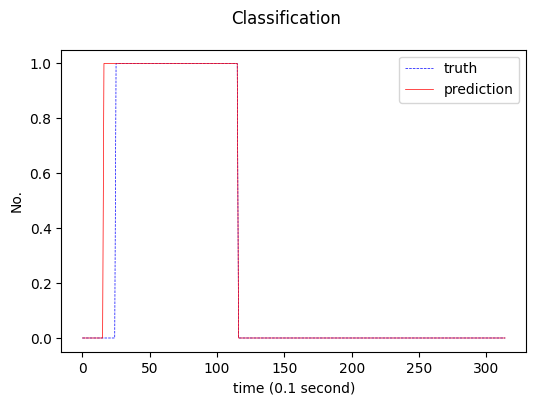

vehicle 61  MSE Loss: 0.01269841


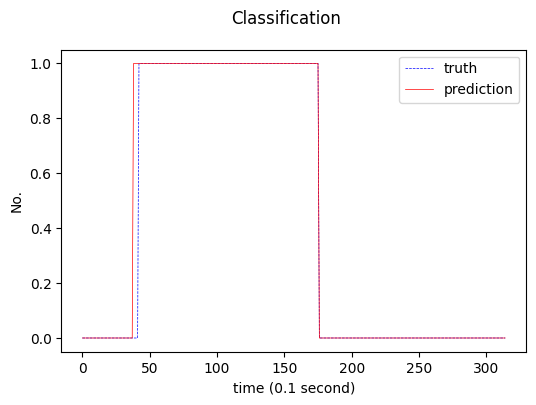

vehicle 62  MSE Loss: 0.01269841


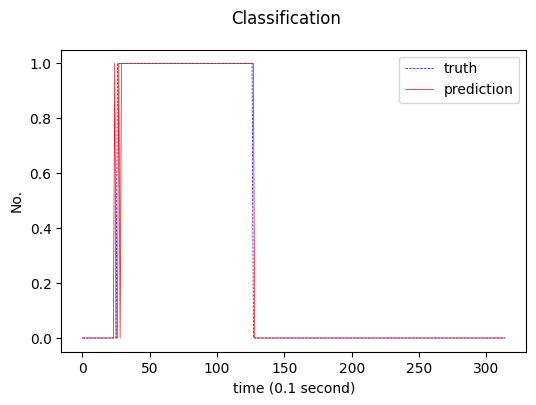

vehicle 63  MSE Loss: 0.00634921


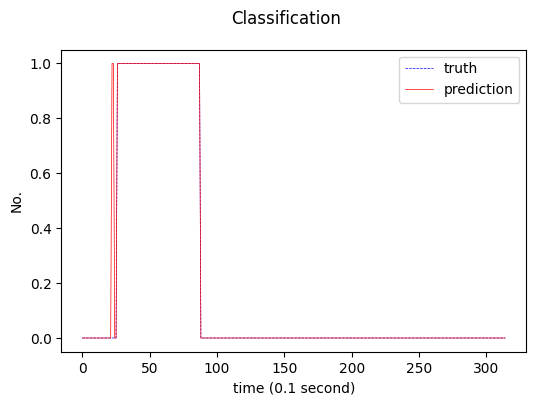

vehicle 64  MSE Loss: 0.01587302


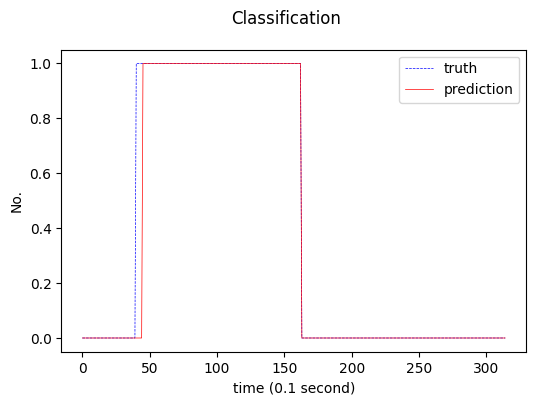

vehicle 65  MSE Loss: 0.01904762


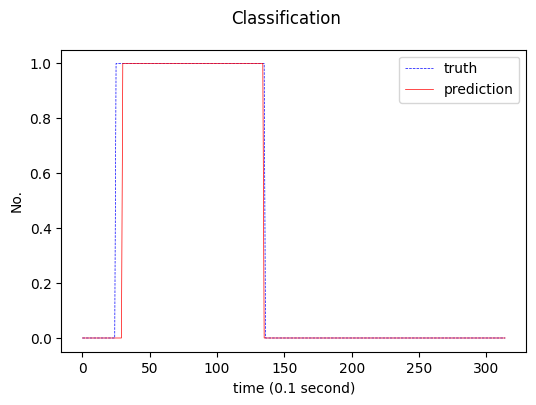

vehicle 66  MSE Loss: 0.01587302


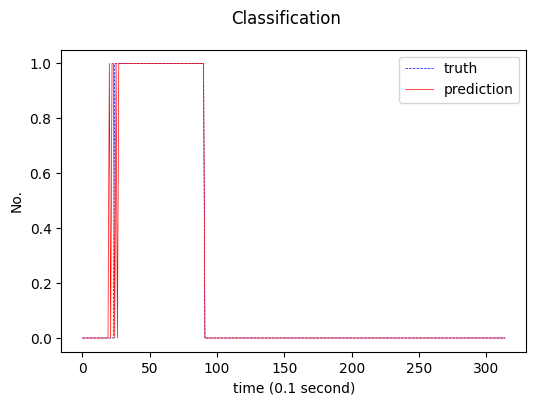

vehicle 67  MSE Loss: 0.01269841


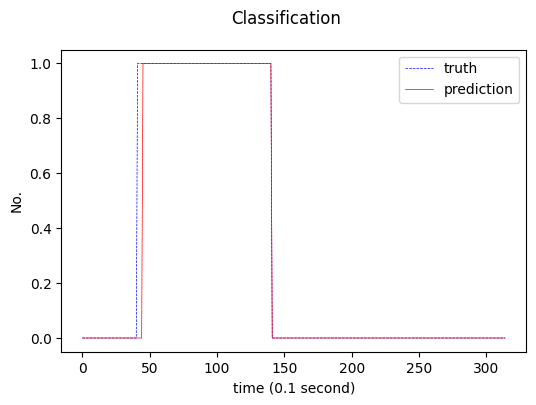

vehicle 68  MSE Loss: 0.01269841


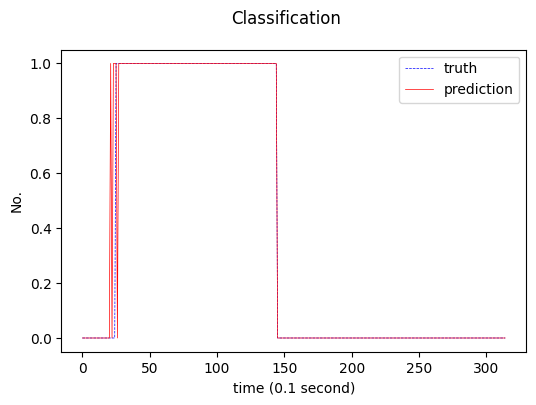

vehicle 69  MSE Loss: 0.03492063


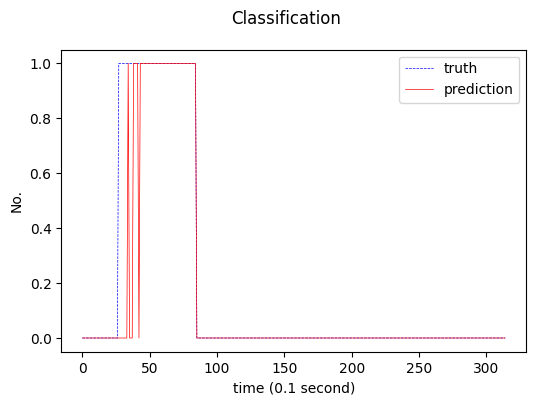

vehicle 70  MSE Loss: 0.00634921


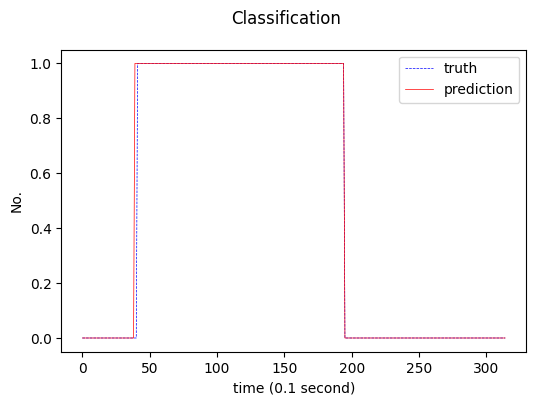

vehicle 71  MSE Loss: 0.00634921


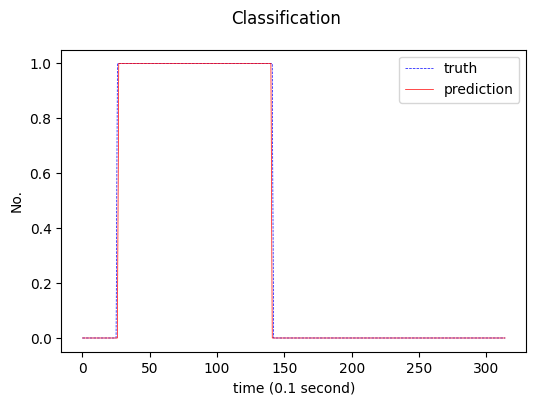

vehicle 72  MSE Loss: 0.00634921


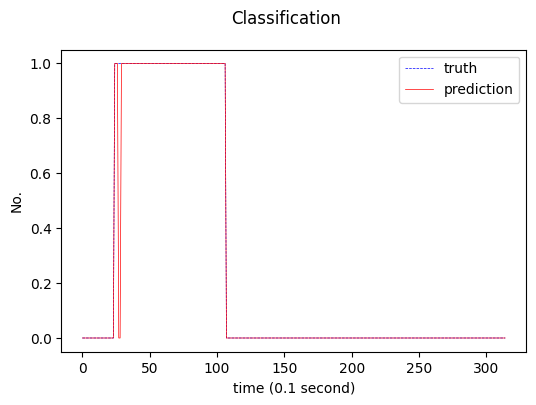

vehicle 73  MSE Loss: 0.01269841


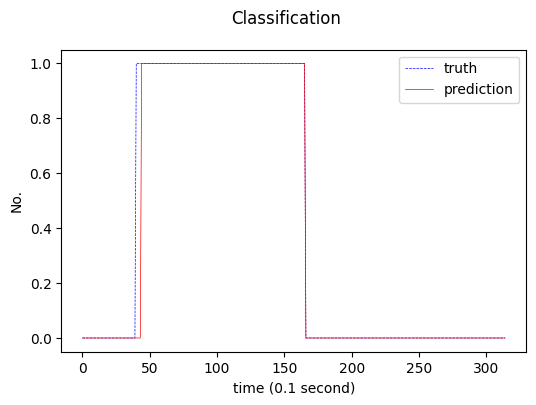

vehicle 74  MSE Loss: 0.02857143


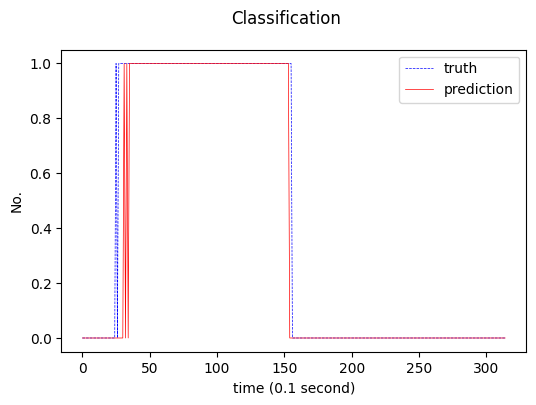

vehicle 75  MSE Loss: 0.01587302


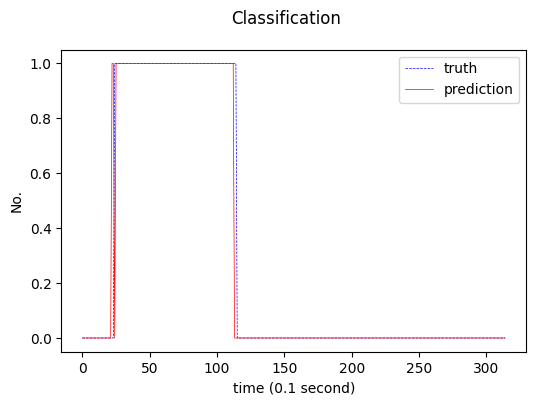

vehicle 76  MSE Loss: 0.00634921


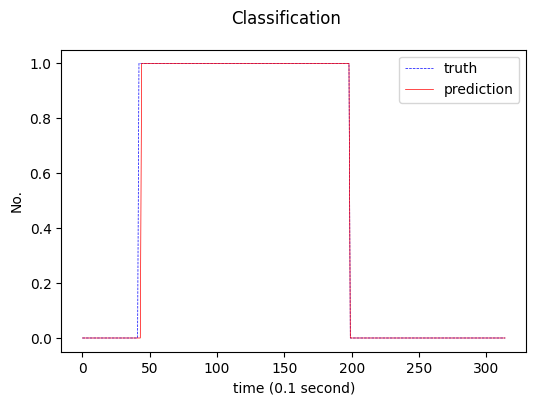

vehicle 77  MSE Loss: 0.00317460


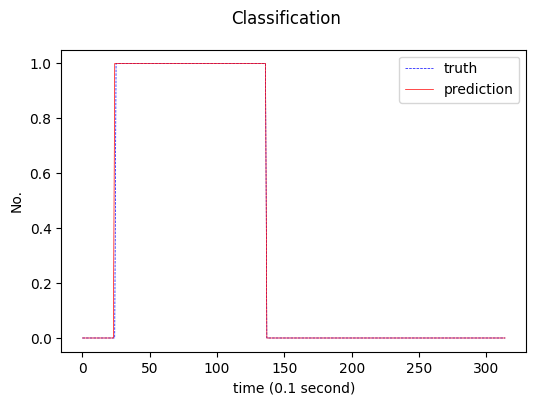

vehicle 78  MSE Loss: 0.05079365


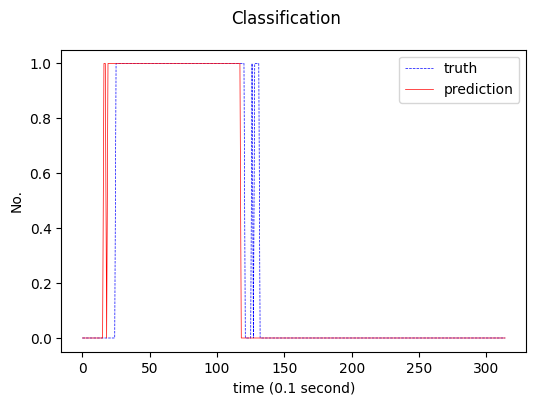

vehicle 79  MSE Loss: 0.00317460


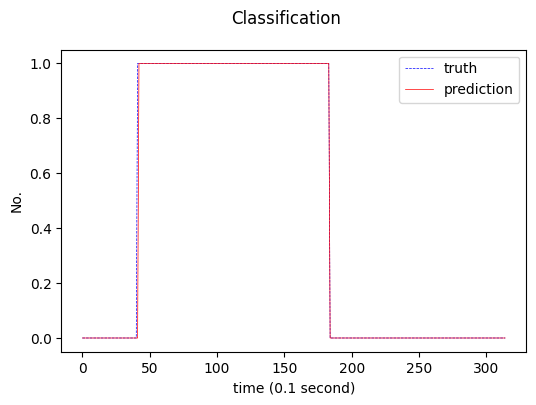

vehicle 80  MSE Loss: 0.00952381


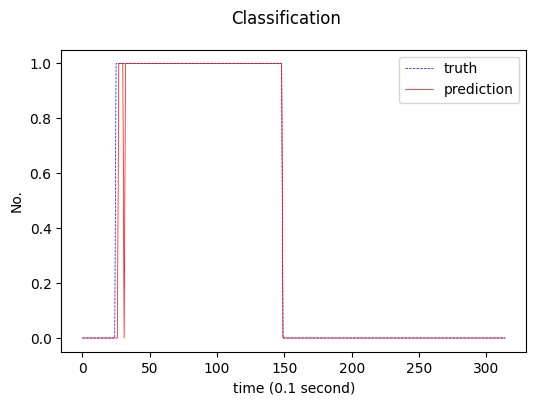

vehicle 81  MSE Loss: 0.02222222


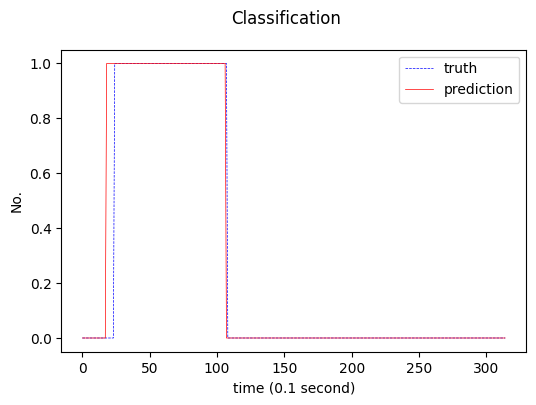

vehicle 82  MSE Loss: 0.00952381


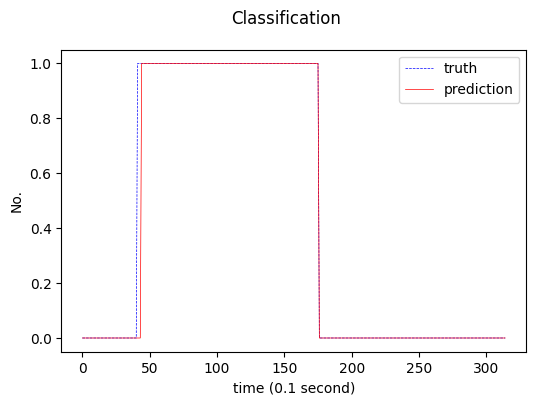

vehicle 83  MSE Loss: 0.01587302


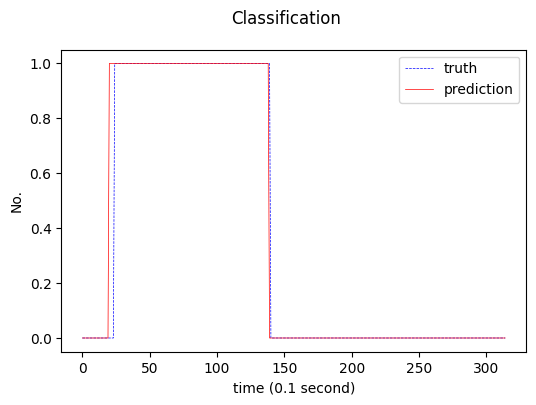

vehicle 84  MSE Loss: 0.01587302


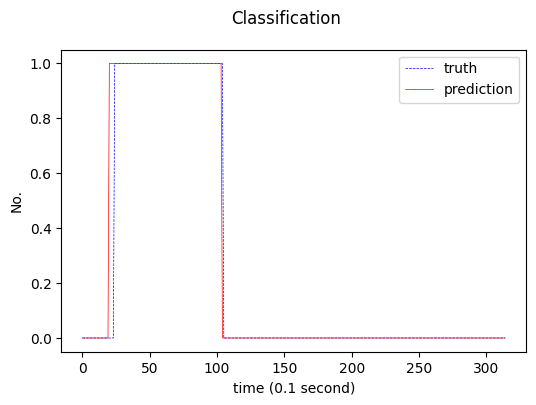

vehicle 85  MSE Loss: 0.00952381


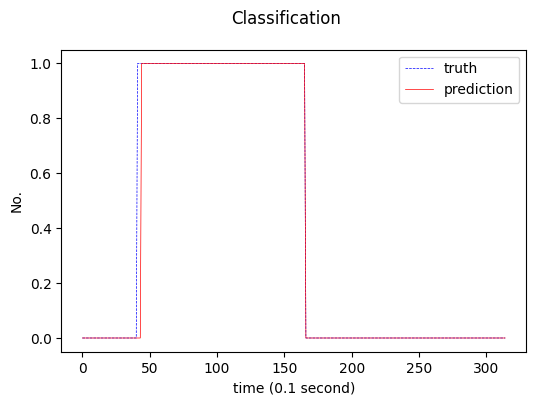

vehicle 86  MSE Loss: 0.00634921


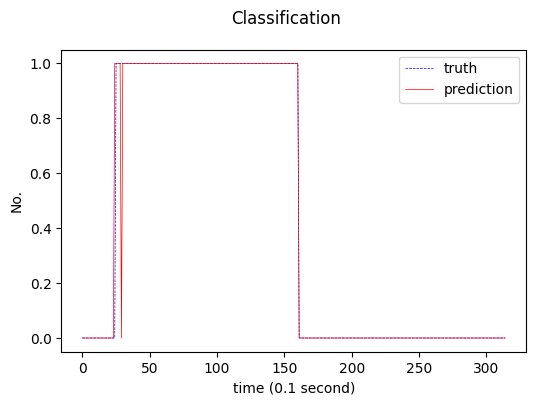

vehicle 87  MSE Loss: 0.01587302


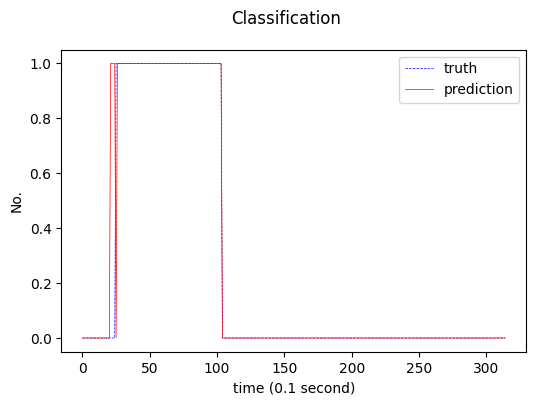

vehicle 88  MSE Loss: 0.00000000


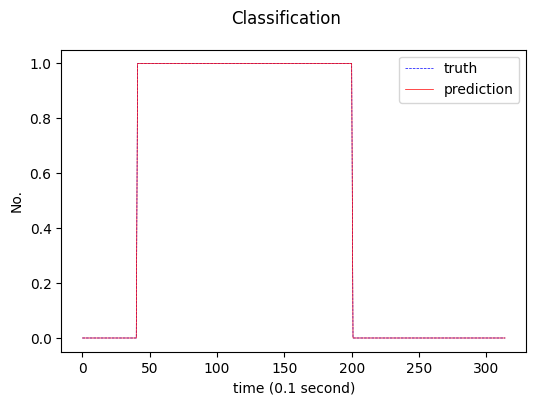

vehicle 89  MSE Loss: 0.03809524


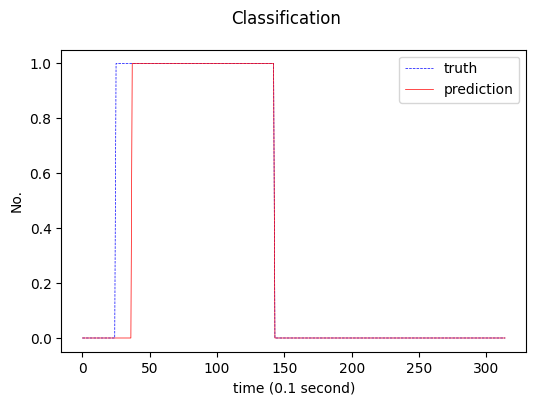

vehicle 90  MSE Loss: 0.06984127


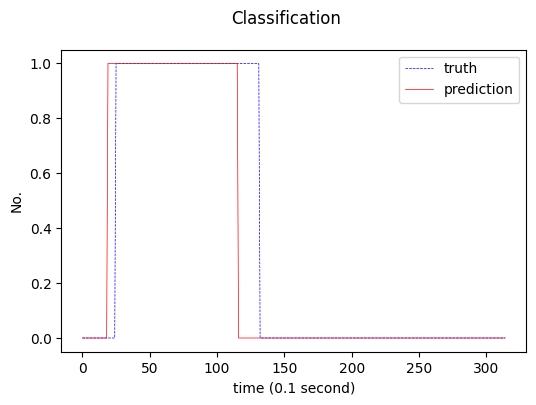

vehicle 91  MSE Loss: 0.01587302


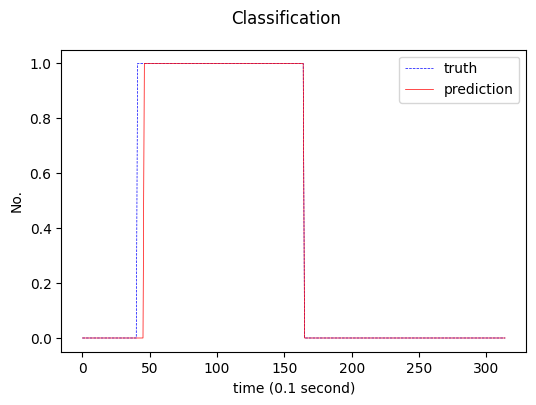

vehicle 92  MSE Loss: 0.00634921


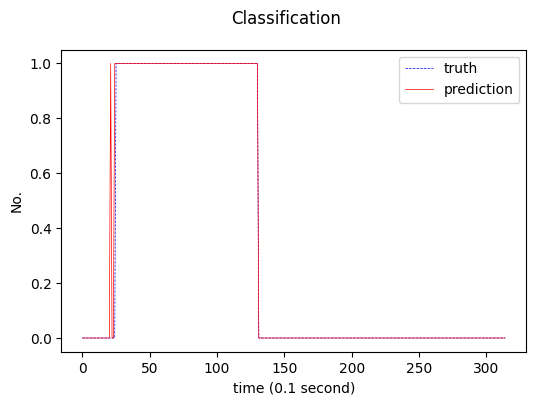

vehicle 93  MSE Loss: 0.01587302


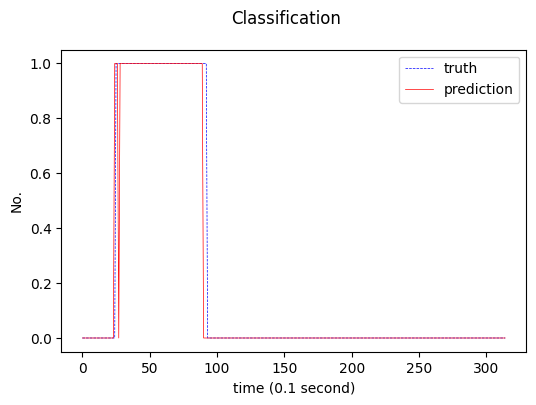

vehicle 94  MSE Loss: 0.00634921


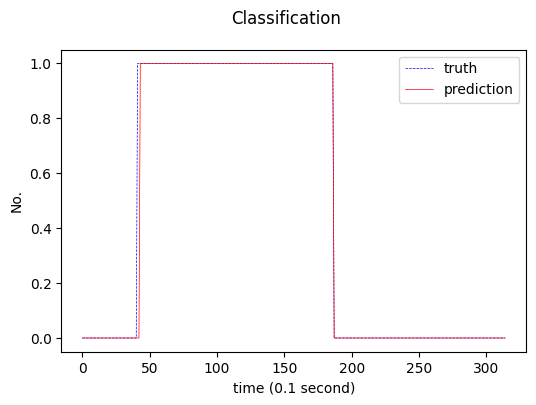

vehicle 95  MSE Loss: 0.05714286


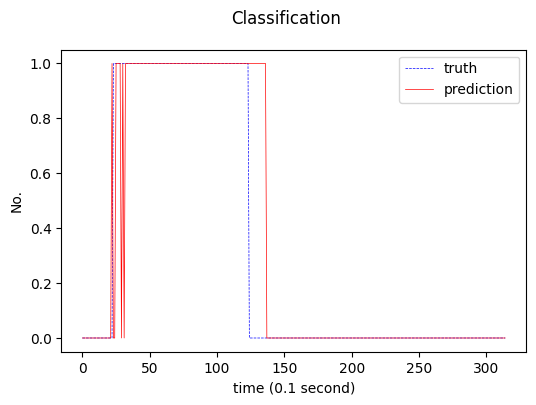

vehicle 96  MSE Loss: 0.01587302


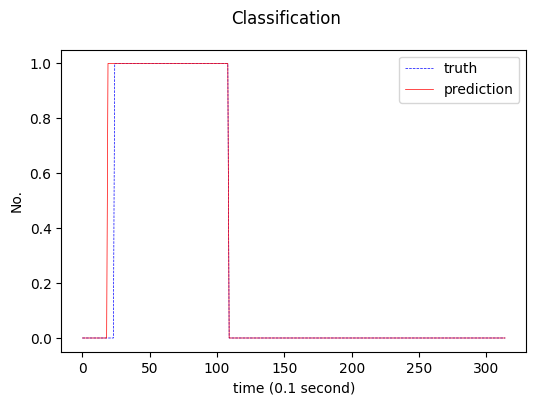

vehicle 97  MSE Loss: 0.01269841


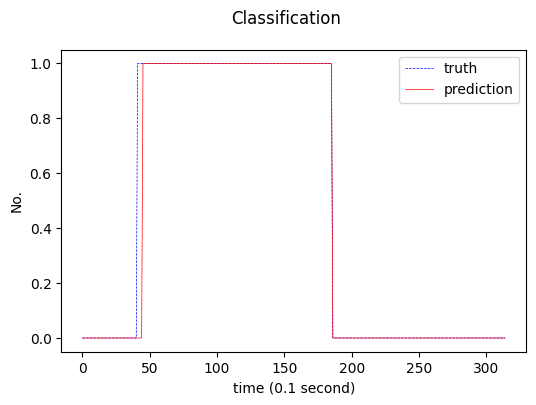

vehicle 98  MSE Loss: 0.00634921


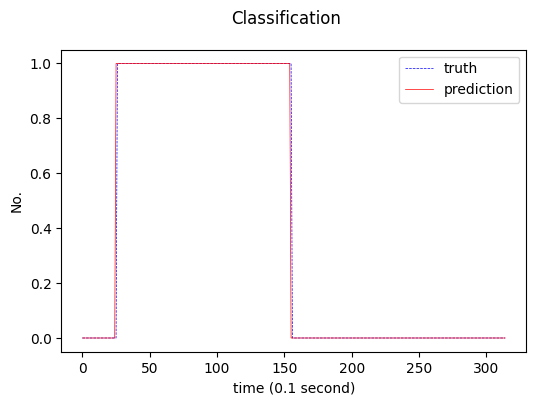

vehicle 99  MSE Loss: 0.06349206


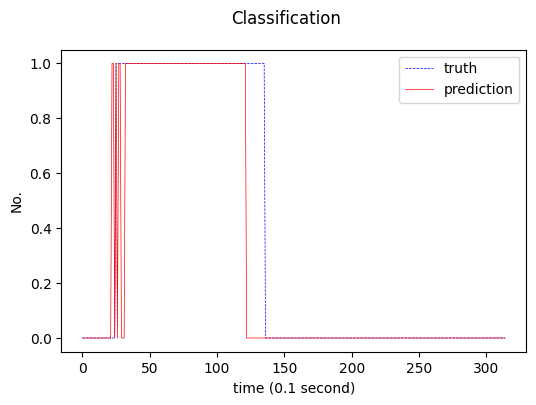

average MSE loss: 0.016158730158730147


In [8]:
MSE = []
num_test = testing_size
test_X = Variable(torch.empty(sample_len, seq_length, 3))
test_Y = Variable(torch.empty(sample_len,1))
    
for k in range(testing_size):
    test_X = testX[k*sample_len:k*sample_len+sample_len] # 0 to test_size
    test_Y = testY[k*sample_len:k*sample_len+sample_len]

    test_X = test_X.to(device)
    test_Y = test_Y.to(device)
    ##########################################
    model.eval()
    predict = model.run(test_X)
    
    loss = (np.square(predict.cpu().data.numpy() - test_Y.cpu().data.numpy())).mean(axis=None)
    #loss = nn.MSELoss(predict, test_Y)
    MSE.append(loss)
    print("vehicle %d  MSE Loss: %1.8f" % (k, loss.item()))
    plt.figure(dpi=100)
    plt.plot(predict.cpu().data.numpy(),c='b', linewidth=0.5, label = 'truth', linestyle='dashed')
    plt.plot(test_Y.cpu().data.numpy(),c='r', linewidth=0.5, label = 'prediction')
    plt.xlabel('time (0.1 second)')
    plt.ylabel('No.')
    plt.suptitle('Classification')
    plt.legend()
    plt.show()

print('average MSE loss:', sum(MSE)/num_test)
